## <center> Régression de base : prédire l'efficacité énergétique </center>

**Source :** https://www.tensorflow.org/tutorials/keras/regression?hl=fr

Dans un problème de régression , le but est de prédire la sortie d'une valeur continue, comme un prix ou une probabilité. Comparez cela avec un problème de classification , où le but est de sélectionner une classe dans une liste de classes (par exemple, lorsqu'une image contient une pomme ou une orange, en reconnaissant quel fruit est dans l'image).

Ce didacticiel utilise l'ensemble de données Auto MPG classique et montre comment créer des modèles pour prédire l'efficacité énergétique des automobiles de la fin des années 1970 et du début des années 1980. Pour ce faire, vous fournirez aux modèles une description de nombreuses automobiles de cette période. Cette description inclut des attributs tels que les cylindres, la cylindrée, la puissance et le poids.

## Importations

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.11.0


## Jeu de données

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Nettoyage des données

In [5]:
# détection des valeurs nulles 

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
# suppression des valeurs nulles
dataset = dataset.dropna()

In [7]:
# encodage de la colonne "Origin" (catégorique => numérique)
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

<ipython-input-7-3419ee56c5d1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Train/test split

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Visualisation des données

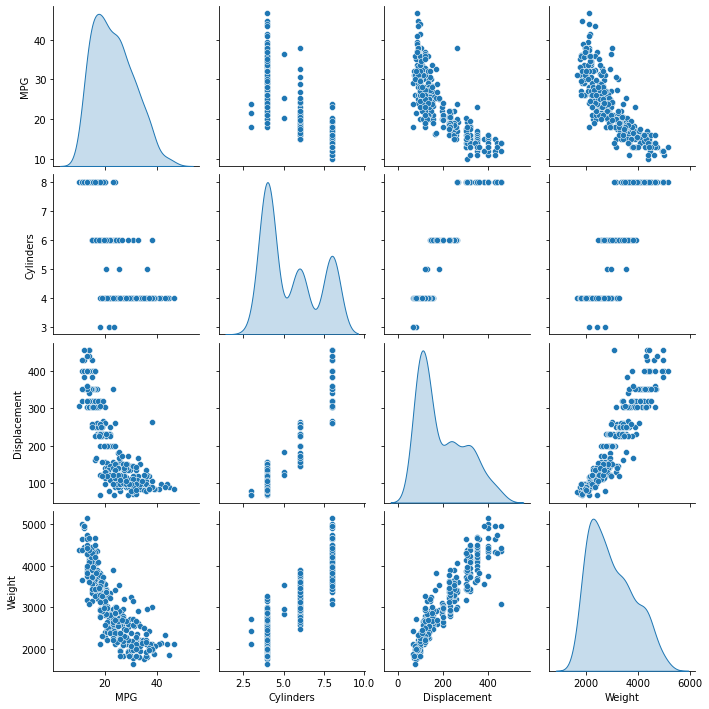

In [9]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

## Description des données 

In [10]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Séparer les entités des étiquettes

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalisation des données

In [12]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [13]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


Lorsque la couche est appelée, elle renvoie les données d'entrée, chaque entité étant normalisée indépendamment :

In [14]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Régression linéaire

Commencez par une régression linéaire à variable unique pour prédire 'MPG' à partir de 'Horsepower' .

In [15]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [16]:
# construction du modèle séquentiel
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Ce modèle prédira 'MPG' à partir de 'Horsepower' .

Exécutez le modèle non formé sur les 10 premières valeurs de "puissance". La sortie ne sera pas bonne, mais notez qu'elle a la forme attendue de (10, 1) :

In [17]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 208ms/step


array([[ 0.429],
       [ 0.242],
       [-0.792],
       [ 0.601],
       [ 0.544],
       [ 0.214],
       [ 0.644],
       [ 0.544],
       [ 0.142],
       [ 0.242]], dtype=float32)

## Compilation du modèle

In [18]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

## Entraînement du modèle

In [19]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.37 s, sys: 150 ms, total: 4.52 s
Wall time: 4.68 s


In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.806026,4.207043,95
96,3.805097,4.188571,96
97,3.804837,4.192785,97
98,3.803343,4.192994,98
99,3.802535,4.169776,99


## Visualisation

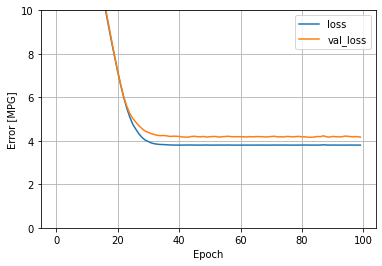

In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)


plot_loss(history)

## Récupérer les données de test

In [22]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

## Visualiser les prédictions du modèle en fonction de l'entrée

In [23]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


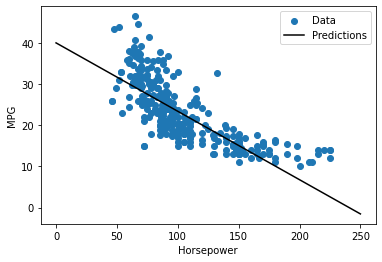

In [24]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)

## Régression linéaire avec plusieurs entrées
Vous pouvez utiliser une configuration presque identique pour effectuer des prédictions basées sur plusieurs entrées. Ce modèle fait toujours le même 
 **y = mx + b** sauf que **m** est une matrice et **b** est un vecteur.

In [25]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [26]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 61ms/step


array([[-1.87 ],
       [ 0.038],
       [ 2.445],
       [-0.642],
       [-0.289],
       [ 0.829],
       [-0.513],
       [-1.723],
       [-0.032],
       [-0.974]], dtype=float32)

In [27]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

### Entraînement sur 100 epochs

In [28]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 4.84 s, sys: 138 ms, total: 4.98 s
Wall time: 5.23 s


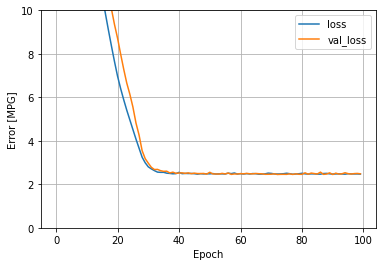

In [29]:
plot_loss(history)

In [30]:
# résultats sur le jeu de test
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Régression avec un réseau de neurones profond (DNN)

Ces modèles contiendront quelques couches de plus que le modèle linéaire :

- La couche de normalisation, comme avant (avec `horsepower_normalizer` pour un modèle à entrée unique et `normalizer` pour un modèle à entrées multiples).
- Deux couches cachées, non linéaires et `Dense` avec la non-linéarité de la fonction d'activation ReLU (`relu`).
- Une couche `Dense` linéaire à sortie unique.

Les deux modèles utiliseront la même procédure de formation, de sorte que la méthode de compile est incluse dans la fonction `build_and_compile_model` ci-dessous.

In [31]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Régression utilisant un DNN et une seule entrée

Créez un modèle DNN avec uniquement `'Horsepower'` comme entrée et `horsepower_normalizer` (défini précédemment) comme couche de normalisation :

In [32]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [33]:
# paramètres du modèles 
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


### Entraînement du modèle

In [34]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 5.67 s, sys: 137 ms, total: 5.8 s
Wall time: 6.33 s


### Visualisation 

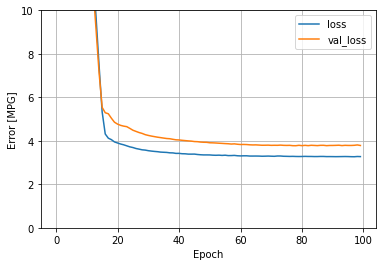

In [35]:
plot_loss(history)

8/8 [==============================] - 0s 2ms/step


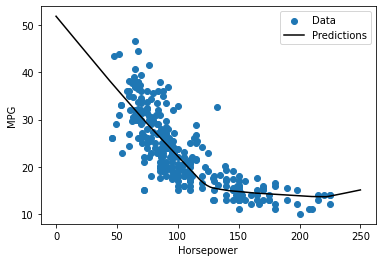

In [36]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

In [37]:
# résultats sur le jeu de test
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

## Régression utilisant un DNN et plusieurs entrées

Répétez le processus précédent en utilisant toutes les entrées. Les performances du modèle s'améliorent légèrement sur l'ensemble de données de validation.

In [40]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [41]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6.11 s, sys: 178 ms, total: 6.29 s
Wall time: 7.2 s


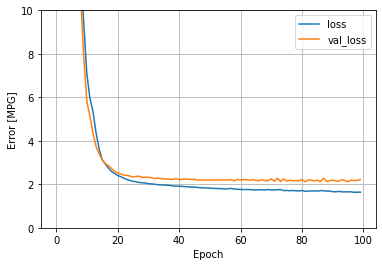

In [42]:
plot_loss(history)

In [43]:
# résulats sur le jeu de test
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

In [44]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.637423
linear_model,2.483572
dnn_horsepower_model,2.916446
dnn_model,1.607424


## Prédictions

3/3 [==============================] - 0s 4ms/step


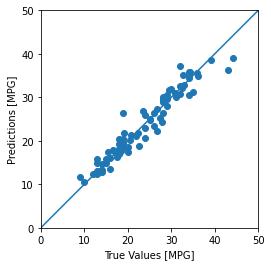

In [46]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Distribution des erreurs

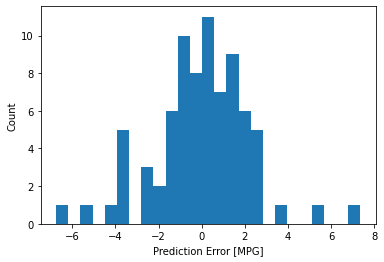

In [47]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

## Sauvegarder un modèle

In [48]:
# dnn_model.save('dnn_model')

## Charger un modèle

In [ ]:
# reloaded = tf.keras.models.load_model('dnn_model')

## Tester avec le nouveau modèle

In [ ]:
# test_results['reloaded'] = reloaded.evaluate(
#     test_features, test_labels, verbose=0)

# # affichage du dataframe
# pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T